<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset_%5BRUGD%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset, namely [RUGD](http://rugd.vision/). In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 4.0 MB 18.5 MB/s 
     |████████████████████████████████| 325 kB 56.4 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 880 kB 65.4 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 59.5 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 136 kB 77.5 MB/s 
     |████████████████████████████████| 127 kB 61.4 MB/s 
     |████████████████████████████████| 271 kB 73.6 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 74.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset


class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "annotations")
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          print(files)
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        annotation = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # make 2D segmentation map (based on 3D one)
        # thanks a lot, Stackoverflow: https://stackoverflow.com/questions/61897492/finding-the-number-of-pixels-in-a-numpy-array-equal-to-a-given-color
        annotation = np.array(annotation)
        annotation_2d = np.zeros((annotation.shape[0], annotation.shape[1]), dtype=np.uint8) # height, width

        for id, color in id2color.items():
            annotation_2d[(annotation == color).all(axis=-1)] = id

        # randomly crop + pad both image and segmentation map to same size
        # feature extractor will also reduce labels!
        encoded_inputs = self.feature_extractor(image, Image.fromarray(annotation_2d), return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
import pandas as pd

# read in RUGD's color palette
color_map = pd.read_csv('/content/drive/MyDrive/SegFormer/Notebooks/Tutorial notebooks/RUGD/RUGD_sample-data/RUGD_annotation-colormap.txt',
                              sep=" ",
                              header=None)
color_map.columns = ["label_idx", "label", "R", "G", "B"]
color_map.head()

,label_idx,label,R,G,B
0,0,void,0,0,0
1,1,dirt,108,64,20
2,2,sand,255,229,204
3,3,grass,0,102,0
4,4,tree,0,255,0


In [ ]:
label2id = {label: id for id, label in enumerate(color_map.label)}
id2label = {id: label for id, label in enumerate(color_map.label)}
print(id2label)

{0: 'void', 1: 'dirt', 2: 'sand', 3: 'grass', 4: 'tree', 5: 'pole', 6: 'water', 7: 'sky', 8: 'vehicle', 9: 'container/generic-object', 10: 'asphalt', 11: 'gravel', 12: 'building', 13: 'mulch', 14: 'rock-bed', 15: 'log', 16: 'bicycle', 17: 'person', 18: 'fence', 19: 'bush', 20: 'sign', 21: 'rock', 22: 'bridge', 23: 'concrete', 24: 'picnic-table'}


In [ ]:
len(id2label)

25

In [ ]:
id2color = {id: [R,G,B] for id, (R,G,B) in enumerate(zip(color_map.R, color_map.G, color_map.B))}
print(id2color)

{0: [0, 0, 0], 1: [108, 64, 20], 2: [255, 229, 204], 3: [0, 102, 0], 4: [0, 255, 0], 5: [0, 153, 153], 6: [0, 128, 255], 7: [0, 0, 255], 8: [255, 255, 0], 9: [255, 0, 127], 10: [64, 64, 64], 11: [255, 128, 0], 12: [255, 0, 0], 13: [153, 76, 0], 14: [102, 102, 0], 15: [102, 0, 0], 16: [0, 255, 128], 17: [204, 153, 255], 18: [102, 0, 204], 19: [255, 153, 204], 20: [0, 102, 102], 21: [153, 204, 255], 22: [102, 255, 255], 23: [101, 101, 11], 24: [114, 85, 47]}


In [ ]:
id2color[label2id["tree"]]

[0, 255, 0]

Let's initialize the training dataset. 

As we can see above, the dataset includes a "void" class (with id=0). However, this class isn't included in the annotation maps (the "void" class isn't part of the 24 labels), hence we initialize the feature extractor with `reduce_labels=True` to make it reduce all labels by one.

This makes sure that the ground truth label tensors contain values between 0 and 23.



In [ ]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/drive/MyDrive/SegFormer/Notebooks/Tutorial notebooks/RUGD/RUGD_sample-data'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)

['creek_00001.png', 'creek_02001.png', 'park-1_00001.png', 'park-1_02001.png', 'park-2_00501.png', 'park-2_02001.png', 'park-8_00001.png', 'trail_00001.png', 'trail_02001.png', 'trail-3_02001.png', 'trail-3_00001.png', 'trail-4_02001.png', 'trail-4_00001.png', 'trail-5_00001.png', 'trail-6_00001.png', 'trail-6_02001.png', 'trail-7_00001.png', 'trail-9_00001.png', 'trail-10_00001.png', 'trail-11_02001.png', 'trail-11_00001.png', 'trail-12_00501.png', 'trail-13_00001.png', 'trail-15_00001.png', 'village_00003.png', 'trail-14_01001.png']


In [ ]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 26


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        ...,
        [ 1,  1,  1,  ..., 13, 13, 13],
        [ 1,  1,  1,  ..., 13, 13, 13],
        [ 1,  1,  1,  ..., 13, 13, 13]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0,  1,  2,  3,  5,  6,  7,  8, 13, 18, 20, 21])

Next, we define a corresponding dataloader.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
batch["labels"][mask]

tensor([ 3,  3,  3,  ..., 12, 12, 12])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

As we've reduced all labels by one above, we need to update our `id2color` and `id2label` mappings first.

In [ ]:
del id2color[0]

id2color = {id-1: color for id, color in id2color.items()}
print(id2color)

In [ ]:
del id2label[0]

label2id = {label: id-1 for id, label in id2label.items()}
id2label = {id-1: label for id, label in id2label.items()}
print(id2label)

{0: 'dirt', 1: 'sand', 2: 'grass', 3: 'tree', 4: 'pole', 5: 'water', 6: 'sky', 7: 'vehicle', 8: 'container/generic-object', 9: 'asphalt', 10: 'gravel', 11: 'building', 12: 'mulch', 13: 'rock-bed', 14: 'log', 15: 'bicycle', 16: 'person', 17: 'fence', 18: 'bush', 19: 'sign', 20: 'rock', 21: 'bridge', 22: 'concrete', 23: 'picnic-table'}


In [ ]:
from transformers import SegformerForSemanticSegmentation

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=24, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.pro

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # we use _compute for now which fixes an issue in speed
          # see this Github thread for more info: 
          metrics = metric._compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/13 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Loss: 3.1117396354675293
Mean_iou: 0.008521427354599717
Mean accuracy: 0.05577154974371539
Epoch: 1


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 2.4128577709198
Mean_iou: 0.06302269650495362
Mean accuracy: 0.10450061891079597
Epoch: 2


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.9531512260437012
Mean_iou: 0.11517893508336428
Mean accuracy: 0.1754744878052804
Epoch: 3


  0%|          | 0/13 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Loss: 1.6515452861785889
Mean_iou: 0.12330922430485176
Mean accuracy: 0.17605111239322088
Epoch: 4


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.397606372833252
Mean_iou: 0.13691494954526834
Mean accuracy: 0.18194404386784138
Epoch: 5


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.4061923027038574
Mean_iou: 0.13720373743798903
Mean accuracy: 0.1870019408375656
Epoch: 6


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.3921983242034912
Mean_iou: 0.14381844580145306
Mean accuracy: 0.192615697012554
Epoch: 7


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.5108797550201416
Mean_iou: 0.16519889636161056
Mean accuracy: 0.21208812464414165
Epoch: 8


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.1652437448501587
Mean_iou: 0.18516031341089167
Mean accuracy: 0.2320588632382439
Epoch: 9


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.9891365766525269
Mean_iou: 0.19737694964458843
Mean accuracy: 0.24409521575576418
Epoch: 10


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.6276850700378418
Mean_iou: 0.18707608794648803
Mean accuracy: 0.240539308078946
Epoch: 11


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.8608648180961609
Mean_iou: 0.22471675916176012
Mean accuracy: 0.25900914987958035
Epoch: 12


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7964590787887573
Mean_iou: 0.22977376839926278
Mean accuracy: 0.2724852359851655
Epoch: 13


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.369412899017334
Mean_iou: 0.2413482166975132
Mean accuracy: 0.2966712315042337
Epoch: 14


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7387737035751343
Mean_iou: 0.28729887731218506
Mean accuracy: 0.31774533410765754
Epoch: 15


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7211718559265137
Mean_iou: 0.28581253400803014
Mean accuracy: 0.32713104566108747
Epoch: 16


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7546616792678833
Mean_iou: 0.2785046541313975
Mean accuracy: 0.3225605052753911
Epoch: 17


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.6604791879653931
Mean_iou: 0.2942082790560265
Mean accuracy: 0.34115857213469963
Epoch: 18


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7967817783355713
Mean_iou: 0.3176620668955822
Mean accuracy: 0.36216532467602786
Epoch: 19


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7914907336235046
Mean_iou: 0.3032644485380958
Mean accuracy: 0.3468752508622712
Epoch: 20


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.6956932544708252
Mean_iou: 0.32193137591823145
Mean accuracy: 0.3653000553240808
Epoch: 21


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7975912094116211
Mean_iou: 0.32739092343431
Mean accuracy: 0.3751158656006698
Epoch: 22


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 1.1910358667373657
Mean_iou: 0.29347120870594795
Mean accuracy: 0.3365730825881782
Epoch: 23


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7411315441131592
Mean_iou: 0.3438957870050943
Mean accuracy: 0.39986511953143267
Epoch: 24


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.6940949559211731
Mean_iou: 0.3483965919410132
Mean accuracy: 0.3862909705266003
Epoch: 25


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.4664607346057892
Mean_iou: 0.351826610326745
Mean accuracy: 0.39707786352935864
Epoch: 26


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.5596187114715576
Mean_iou: 0.3406233933876491
Mean accuracy: 0.39045725282547766
Epoch: 27


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.47977495193481445
Mean_iou: 0.3809878770496243
Mean accuracy: 0.4150605841118589
Epoch: 28


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.4647689759731293
Mean_iou: 0.36591304072358405
Mean accuracy: 0.41173172511907175
Epoch: 29


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.3922695815563202
Mean_iou: 0.366002043351699
Mean accuracy: 0.4127212500073936
Epoch: 30


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.6724632978439331
Mean_iou: 0.4095248957949984
Mean accuracy: 0.4415126689743984
Epoch: 31


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7608432173728943
Mean_iou: 0.34231646373060687
Mean accuracy: 0.38897880451142086
Epoch: 32


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.7189778685569763
Mean_iou: 0.4387149334644569
Mean accuracy: 0.4826822983547943
Epoch: 33


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.8207771182060242
Mean_iou: 0.3806304798320265
Mean accuracy: 0.41286104232781434
Epoch: 34


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.5999752283096313
Mean_iou: 0.41385938756632146
Mean accuracy: 0.4534271255484056
Epoch: 35


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.5382042527198792
Mean_iou: 0.4234731322231863
Mean accuracy: 0.4637478808719841
Epoch: 36


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.45409253239631653
Mean_iou: 0.40002003156748034
Mean accuracy: 0.4409023621397257
Epoch: 37


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.5535038113594055
Mean_iou: 0.42247683832069016
Mean accuracy: 0.46091911319926915
Epoch: 38


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.415310263633728
Mean_iou: 0.49222384377722234
Mean accuracy: 0.5332416962772322
Epoch: 39


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.730412483215332
Mean_iou: 0.4311240066151462
Mean accuracy: 0.47007906812540257
Epoch: 40


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.38511788845062256
Mean_iou: 0.411546435657935
Mean accuracy: 0.4476977529512513
Epoch: 41


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.514649510383606
Mean_iou: 0.4505204677870658
Mean accuracy: 0.48886361413417223
Epoch: 42


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.358365535736084
Mean_iou: 0.44225286459733243
Mean accuracy: 0.4764442424326473
Epoch: 43


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.4025633931159973
Mean_iou: 0.43109055722438006
Mean accuracy: 0.4658945175896593
Epoch: 44


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.43879789113998413
Mean_iou: 0.4640351238893562
Mean accuracy: 0.4940656036735463
Epoch: 45


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.48022061586380005
Mean_iou: 0.4643291539720506
Mean accuracy: 0.5031286657458452
Epoch: 46


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.31514790654182434
Mean_iou: 0.4670515147975957
Mean accuracy: 0.5064630524854372
Epoch: 47


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.28024959564208984
Mean_iou: 0.4561429554739998
Mean accuracy: 0.49300901684080495
Epoch: 48


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.28419029712677
Mean_iou: 0.4726986834965952
Mean accuracy: 0.5138492535122431
Epoch: 49


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.38435325026512146
Mean_iou: 0.4710450827423917
Mean accuracy: 0.5112692387195535
Epoch: 50


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.292301744222641
Mean_iou: 0.47674026578991596
Mean accuracy: 0.5163970366045358
Epoch: 51


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.2878541350364685
Mean_iou: 0.48638419022528223
Mean accuracy: 0.5183230342540407
Epoch: 52


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.3949923515319824
Mean_iou: 0.47199380050221423
Mean accuracy: 0.5111584699015004
Epoch: 53


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.32591912150382996
Mean_iou: 0.4818262778967162
Mean accuracy: 0.5179736225979219
Epoch: 54


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.38169312477111816
Mean_iou: 0.48272541889999426
Mean accuracy: 0.5214513330749638
Epoch: 55


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.31104162335395813
Mean_iou: 0.4764175763605982
Mean accuracy: 0.5131192928261021
Epoch: 56


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.3880600333213806
Mean_iou: 0.4899159156288176
Mean accuracy: 0.5290824770917016
Epoch: 57


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.336481511592865
Mean_iou: 0.4726089080930226
Mean accuracy: 0.5162443388449883
Epoch: 58


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.30336421728134155
Mean_iou: 0.49083155892198677
Mean accuracy: 0.5254398153872658
Epoch: 59


  0%|          | 0/13 [00:00<?, ?it/s]

Loss: 0.4000351130962372
Mean_iou: 0.48785511003098014
Mean accuracy: 0.5286091492333597


KeyboardInterrupt: ignored

## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

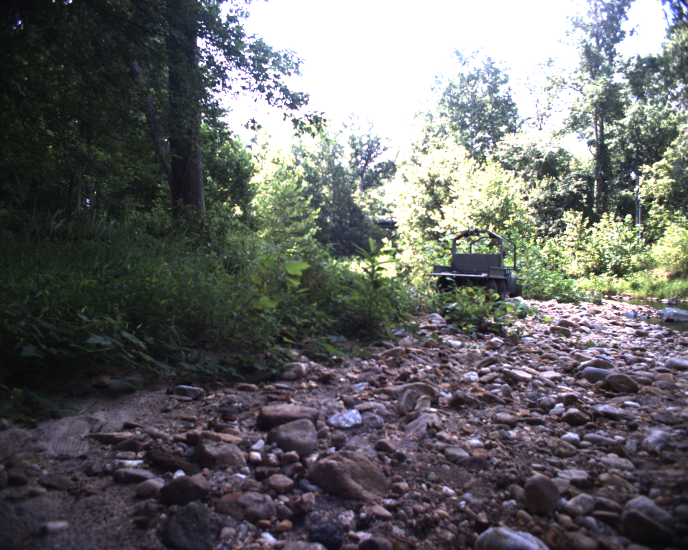

In [ ]:
image = Image.open('/content/drive/MyDrive/SegFormer/Notebooks/Tutorial notebooks/RUGD/RUGD_sample-data/images/creek_00001.png')
image

In [ ]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])


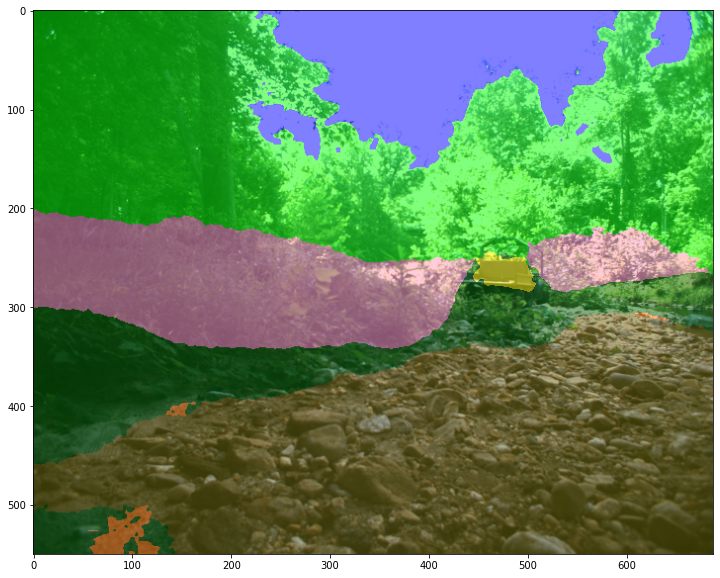

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[seg == label, :] = color

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's print the pure predicted segmentation map:

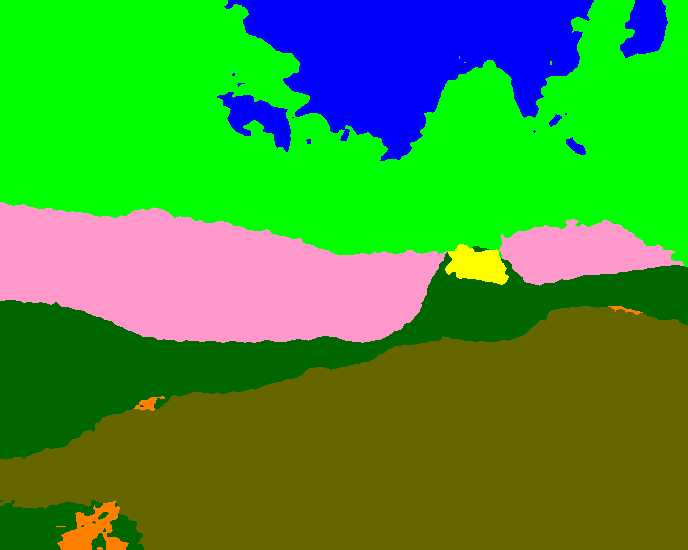

In [ ]:
Image.fromarray(color_seg)

Compare this to the ground truth segmentation map:

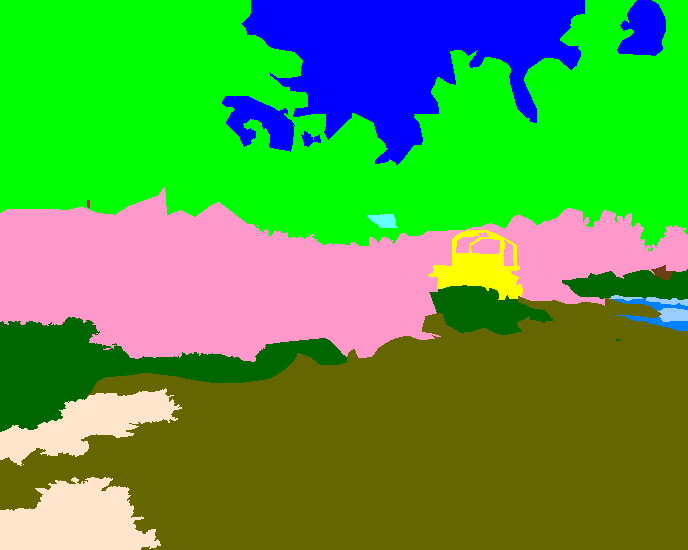

In [ ]:
map = Image.open('/content/drive/MyDrive/SegFormer/Notebooks/Tutorial notebooks/RUGD/RUGD_sample-data/annotations/creek_00001.png') 
map 